In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#from matplotlib impo

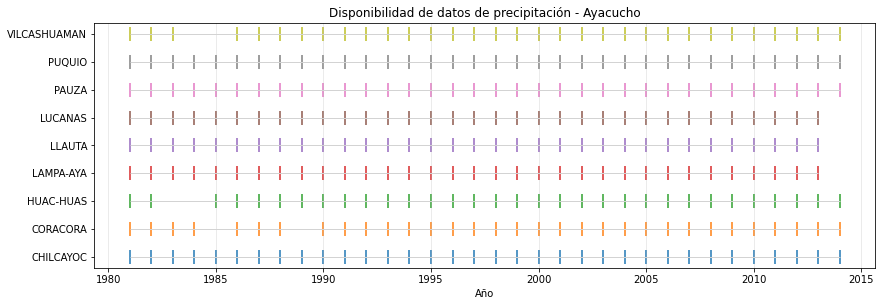

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Ruta principal ===
base_dir = "D:/S/SENAMHI PERU"

# === Función para leer una estación ===
def leer_estacion(file_path):
    year, month, day, prec = [], [], [], []
    with open(file_path, "r") as g:
        for line in g:
            s = line.strip().split()
            if len(s) >= 4:
                try:
                    y, m, d, p = int(s[0]), int(s[1]), int(s[2]), float(s[3])
                    if y >= 1981:  # solo desde 1981
                        if p == -99.9:  # NA en datos faltantes
                            p = None
                        year.append(y)
                        month.append(m)
                        day.append(d)
                        prec.append(p)
                except:
                    continue
    if not year:
        return None
    fechas = pd.to_datetime({"year": year, "month": month, "day": day}, errors="coerce")
    return pd.DataFrame({"Fecha": fechas, "prec": prec})

# === Graficar disponibilidad de datos en un departamento ===
def plot_disponibilidad(departamento):
    dept_path = os.path.join(base_dir, departamento)
    estaciones = [f for f in os.listdir(dept_path) if f.endswith(".txt")]
    
    plt.figure(figsize=(14, len(estaciones) * 0.5))
    
    for i, est in enumerate(estaciones):
        df = leer_estacion(os.path.join(dept_path, est))
        if df is not None:
            df["año"] = df["Fecha"].dt.year
            # serie booleana: si ese año tuvo datos válidos
            disponibilidad = df.dropna().groupby("año").size()
            años = disponibilidad.index
            # Dibujamos línea horizontal para cada estación
            plt.hlines(i, min(años), max(años), color="lightgray", linewidth=1)
            plt.scatter(años, [i]*len(años), marker="|", s=200, label=est.replace(".txt", ""))
    
    plt.yticks(range(len(estaciones)), [e.replace(".txt","") for e in estaciones])
    plt.xlabel("Año")
    plt.title(f"Disponibilidad de datos de precipitación - {departamento}")
    plt.grid(axis="x", alpha=0.3)
    plt.show()

# === Ejemplo: San Martin ===
plot_disponibilidad("Ayacucho")


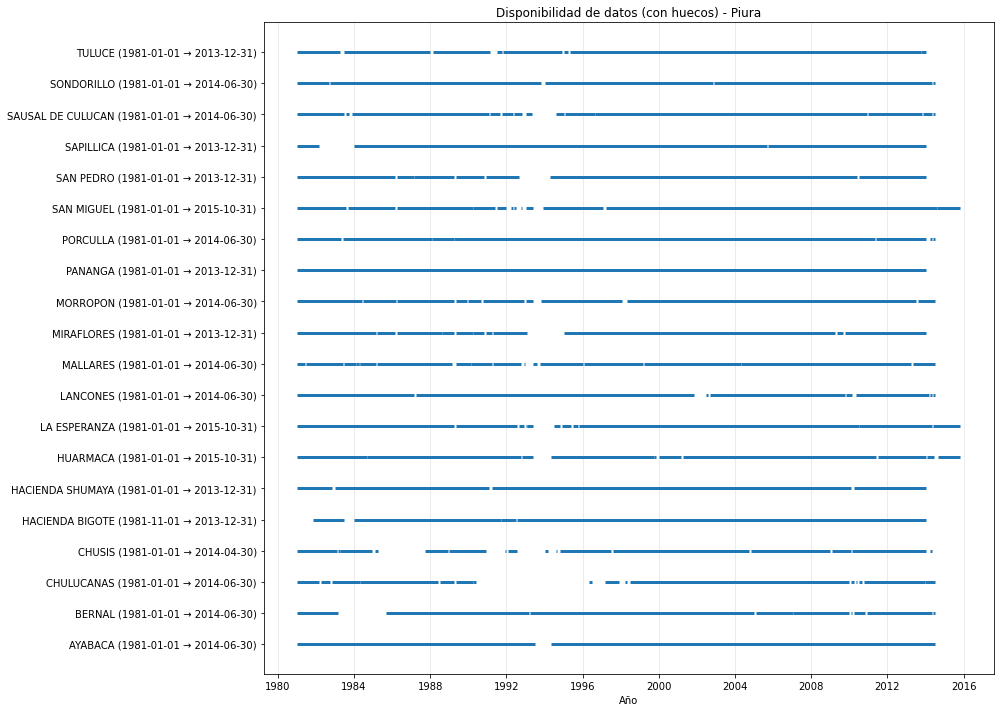

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Ruta principal ===
base_dir = "D:/S/SENAMHI PERU"

# === Función para leer una estación ===
def leer_estacion(file_path):
    year, month, day, prec = [], [], [], []
    with open(file_path, "r") as g:
        for line in g:
            s = line.strip().split()
            if len(s) >= 4:
                try:
                    y, m, d, p = int(s[0]), int(s[1]), int(s[2]), float(s[3])
                    if y >= 1981:
                        if p == -99.9:  # NA en datos faltantes
                            p = None
                        year.append(y)
                        month.append(m)
                        day.append(d)
                        prec.append(p)
                except:
                    continue
    if not year:
        return None
    fechas = pd.to_datetime({"year": year, "month": month, "day": day}, errors="coerce")
    return pd.DataFrame({"Fecha": fechas, "prec": prec})

# === Graficar disponibilidad con huecos visibles ===
def plot_disponibilidad(departamento):
    dept_path = os.path.join(base_dir, departamento)
    estaciones = [f for f in os.listdir(dept_path) if f.endswith(".txt")]
    
    resumen = []
    plt.figure(figsize=(14, len(estaciones) * 0.5))
    
    for i, est in enumerate(estaciones):
        df = leer_estacion(os.path.join(dept_path, est))
        if df is not None:
            df_valid = df.copy()
            df_valid["disp"] = df_valid["prec"].notna()  # True si hay dato
            
            if df_valid["disp"].any():
                inicio = df_valid.loc[df_valid["disp"], "Fecha"].min()
                fin = df_valid.loc[df_valid["disp"], "Fecha"].max()
                resumen.append([est.replace(".txt",""), inicio, fin])
                
                # --- dividir en bloques de datos continuos ---
                df_valid["gap"] = (df_valid["disp"] != df_valid["disp"].shift()).cumsum()
                bloques = df_valid[df_valid["disp"]].groupby("gap")
                
                for _, bloque in bloques:
                    plt.hlines(i, bloque["Fecha"].min(), bloque["Fecha"].max(),
                               colors="tab:blue", linewidth=3)
    
    # Etiquetas con nombre + fechas inicio-fin
    etiquetas = [
        f"{est} ({ini.date()} → {fin.date()})"
        for est, ini, fin in resumen
    ]
    
    plt.yticks(range(len(etiquetas)), etiquetas)
    plt.xlabel("Año")
    plt.title(f"Disponibilidad de datos (con huecos) - {departamento}")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

# === Ejemplo: San Martin ===
plot_disponibilidad("Piura")


In [10]:
# === Graficar disponibilidad con huecos visibles ===
def plot_disponibilidad(departamento):
    dept_path = os.path.join(base_dir, departamento)
    estaciones = [f for f in os.listdir(dept_path) if f.endswith(".txt")]
    
    resumen = []
    plt.figure(figsize=(14, len(estaciones) * 0.5))
    
    for i, est in enumerate(estaciones):
        df = leer_estacion(os.path.join(dept_path, est))
        if df is not None:
            df_valid = df.copy()
            df_valid["disp"] = df_valid["prec"].notna()
            
            if df_valid["disp"].any():
                inicio = df_valid.loc[df_valid["disp"], "Fecha"].min()
                fin = df_valid.loc[df_valid["disp"], "Fecha"].max()
                resumen.append([est.replace(".txt",""), inicio, fin])
                
                # --- dividir en bloques de datos continuos ---
                df_valid["gap"] = (df_valid["disp"] != df_valid["disp"].shift()).cumsum()
                bloques = df_valid[df_valid["disp"]].groupby("gap")
                
                for _, bloque in bloques:
                    plt.hlines(i, bloque["Fecha"].min(), bloque["Fecha"].max(),
                               colors="tab:blue", linewidth=3)
    
    # Convertimos el resumen en DataFrame
    resumen_df = pd.DataFrame(resumen, columns=["Estacion", "Inicio", "Fin"])
    
    # --- Mostrar quienes no empiezan en 1981-01-01 ---
    fecha_ref = pd.Timestamp("1981-01-01")
    incompletas = resumen_df[resumen_df["Inicio"] > fecha_ref]
    if not incompletas.empty:
        print("⚠️ Estaciones que NO empiezan en 1981-01-01:")
        print(incompletas.to_string(index=False))
    else:
        print("✅ Todas las estaciones empiezan en 1981-01-01")

    # Etiquetas en gráfico
    etiquetas = [
        f"{row.Estacion} ({row.Inicio.date()} → {row.Fin.date()})"
        for row in resumen_df.itertuples()
    ]
    
    plt.yticks(range(len(etiquetas)), etiquetas)
    plt.xlabel("Año")
    plt.title(f"Disponibilidad de datos (con huecos) - {departamento}")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    #return resumen_df  # <--- lo devolvemos para análisis posterior


⚠️ Estaciones que NO empiezan en 1981-01-01:
  Estacion     Inicio        Fin
POMACANCHI 1985-01-14 2014-06-30


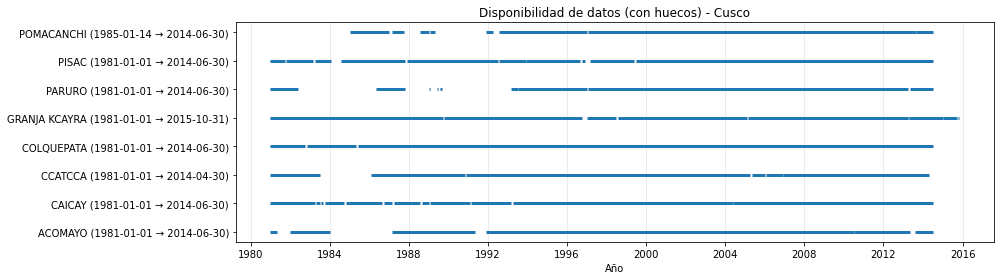

In [46]:
plot_disponibilidad("Cusco")

In [21]:
import os ###################### okkkkkkkkkkkkkk
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# === Ruta principal ===
base_dir = "D:/S/SENAMHI PERU"

# --- 1) Lectura de una estación ---
def leer_estacion(file_path):
    year, month, day, prec = [], [], [], []
    with open(file_path, "r") as g:
        for line in g:
            s = line.strip().split()
            if len(s) >= 4:
                try:
                    y, m, d, p = int(s[0]), int(s[1]), int(s[2]), float(s[3])
                    if y >= 1981:
                        if p == -99.9:  # faltante
                            p = None
                        year.append(y); month.append(m); day.append(d); prec.append(p)
                except:
                    continue
    if not year:
        return None
    fechas = pd.to_datetime({"year": year, "month": month, "day": day}, errors="coerce")
    return pd.DataFrame({"Fecha": fechas, "prec": prec})

# --- 2) Cargar todas las estaciones de una región ---
def cargar_region(region):
    region_dir = os.path.join(base_dir, region)
    estaciones = {}
    for root, _, files in os.walk(region_dir):
        for f in files:
            if f.lower().endswith(".txt"):
                est = os.path.splitext(f)[0].upper().strip()
                df = leer_estacion(os.path.join(root, f))
                if df is not None and "Fecha" in df.columns:
                    df = df.set_index("Fecha").sort_index()
                    estaciones[est] = df["prec"].astype(float)
    if not estaciones:
        raise RuntimeError(f"No se encontraron .txt válidos en {region_dir}")
    
    fecha_min = pd.Timestamp("1981-01-01")
    fecha_max = max(s.index.max() for s in estaciones.values())
    fechas = pd.date_range(fecha_min, fecha_max, freq="D")
    df_region = pd.DataFrame({est: serie.reindex(fechas) for est, serie in estaciones.items()})
    df_region.index.name = "Fecha"
    return df_region

# --- 3) Selección de vecinos confiables ---
def seleccionar_vecinos(df_region, est, min_corr=0.45, max_vecinos=5):
    fecha_inicio_ref = pd.Timestamp("1981-01-01")
    completos = [c for c in df_region.columns if c != est and df_region[c].first_valid_index() == fecha_inicio_ref]
    if not completos:
        return [], []

    y = df_region[est]
    corrs = []
    for c in completos:
        x = df_region[c]
        mask = y.notna() & x.notna()
        if mask.sum() >= 60:
            r = np.corrcoef(y[mask], x[mask])[0, 1]
            if np.isfinite(r):
                corrs.append((c, r))

    corrs = sorted(corrs, key=lambda t: t[1], reverse=True)
    vecinos = [c for c, r in corrs if r >= min_corr][:max_vecinos]
    if not vecinos and corrs:
        vecinos = [c for c, _ in corrs[:max_vecinos]]

    return vecinos, corrs

# --- 4) Completar tramo pre-inicio ---
def completar_pre_inicio(df_region, est, vecinos, corrs_vecinos=None, min_train=10):
    y = df_region[est].copy()
    primer_real = y.dropna().index.min()
    if pd.isna(primer_real) or primer_real <= pd.Timestamp("1981-01-01"):
        return y.fillna(-99.9), pd.DataFrame(), 0, primer_real

    fechas = pd.date_range(pd.Timestamp("1981-01-01"), primer_real, freq="D")
    y = y.reindex(fechas)
    fill_idx = pd.date_range(pd.Timestamp("1981-01-01"), primer_real - pd.Timedelta(days=1), freq="D")
    y_hat = pd.Series(index=fill_idx, dtype=float)

    for mes in range(1, 13):
        idx_mes = fill_idx[fill_idx.month == mes]
        if len(idx_mes) == 0: continue

        idx_mes_full = y.index[y.index.month == mes]
        X_mes_full = df_region.loc[idx_mes_full, vecinos]
        y_mes_full = y.loc[idx_mes_full]

        mask_fit = y_mes_full.notna() & X_mes_full.notna().all(axis=1)
        if mask_fit.sum() >= min_train:
            model = LinearRegression()
            model.fit(X_mes_full[mask_fit], y_mes_full[mask_fit])
            X_pred = df_region.loc[idx_mes, vecinos]
            mask_pred = X_pred.notna().all(axis=1)
            if mask_pred.any():
                y_hat.loc[idx_mes[mask_pred]] = model.predict(X_pred[mask_pred])

        # fallback promedio
        faltan = y_hat.loc[idx_mes].isna()
        if faltan.any():
            X_pred_any = df_region.loc[idx_mes, vecinos]
            y_hat.loc[idx_mes[faltan]] = X_pred_any.mean(axis=1).loc[idx_mes[faltan]]

    y_hat = y_hat.clip(lower=0)
    y_final = y.copy()
    y_final.loc[y_hat.index] = y_hat

    # Log de vecinos con correlación
    if corrs_vecinos is not None:
        resumen_vecinos = pd.DataFrame({
            "Estacion_incompleta": est,
            "Inicio": primer_real,
            "Vecino": [v for v, r in corrs_vecinos if v in vecinos],
            "Correlacion": [r for v, r in corrs_vecinos if v in vecinos]
        })
    else:
        resumen_vecinos = pd.DataFrame()

    return y_final, resumen_vecinos, int(y_hat.notna().sum()), primer_real

# --- 5) Orquestador ---
# --- 5) Orquestador con guardado CSV ---
def completar_region_preinicio(region, min_corr=0.45, max_vecinos=5):
    df_region = cargar_region(region)
    print(f"✅ {region}: {len(df_region.columns)} estaciones cargadas.")

    fecha_ref = pd.Timestamp("1981-01-01")
    incompletas = {col: df_region[col].dropna().index.min()
                   for col in df_region.columns
                   if (df_region[col].dropna().index.min() is not None) and (df_region[col].dropna().index.min() > fecha_ref)}

    if not incompletas:
        print("🎉 Todas las estaciones inician en 1981-01-01. Nada que completar.")
        return

    print("📌 Estaciones a completar (pre-inicio):")
    for est, ini in incompletas.items():
        print(f"   - {est}: primer dato real = {ini.date()}")

    out_dir = os.path.join(base_dir, region, "Completadas_preinicio")
    os.makedirs(out_dir, exist_ok=True)

    for est in incompletas:
        vecinos, corrs = seleccionar_vecinos(df_region, est, min_corr=min_corr, max_vecinos=max_vecinos)
        serie, resumen_vecinos, nfill, primer_real = completar_pre_inicio(
            df_region, est, vecinos[:max_vecinos], corrs_vecinos=corrs
        )

        # Reindex completo desde 1981-01-01 hasta último dato real
        ultimo_real = df_region[est].dropna().index.max()
        fechas_full = pd.date_range("1981-01-01", ultimo_real, freq="D")
        serie_full = serie.reindex(fechas_full)
        serie_full.loc[primer_real:] = df_region[est].loc[primer_real:ultimo_real]

        # Reemplazar NaN por -99.0
        serie_full = serie_full.fillna(-99.9)

        # Guardar CSV
        serie_full.to_csv(
            os.path.join(out_dir, f"{est}_preinicio_completado.csv"),
            header=[est],
            index_label="Fecha",
            float_format="%.1f"
        )

        print(f"✅ {est}: {nfill} días completados hasta {primer_real.date()} con vecinos {vecinos}")

        if not resumen_vecinos.empty:
            print("\nResumen de vecinos y correlaciones:")
            print(resumen_vecinos.to_string(index=False))

# --- EJECUCIÓN ---
completar_region_preinicio("Cusco", min_corr=0.45, max_vecinos=5)


✅ Cusco: 8 estaciones cargadas.
📌 Estaciones a completar (pre-inicio):
   - POMACANCHI: primer dato real = 1985-01-14
✅ POMACANCHI: 1474 días completados hasta 1985-01-14 con vecinos ['ACOMAYO', 'PARURO', 'GRANJA KCAYRA']

Resumen de vecinos y correlaciones:
Estacion_incompleta     Inicio        Vecino  Correlacion
         POMACANCHI 1985-01-14       ACOMAYO     0.634547
         POMACANCHI 1985-01-14        PARURO     0.580689
         POMACANCHI 1985-01-14 GRANJA KCAYRA     0.459874


In [2]:
import os ##################### Obs OKKKKKKKKKKKKKK cmhyd
import pandas as pd
import shutil

# --- Rutas ---
base_dir = r"D:/S/SENAMHI PERU"
region = "Cusco"
region_dir = os.path.join(base_dir, region)
output_dir = "D:/S/CMhyd/Cusco/Obs" # Carpeta nueva
os.makedirs(output_dir, exist_ok=True)

# --- Leer info de estaciones ---
stations_csv = os.path.join(base_dir, "Stations Senamhi.csv")
ubicaciones_df = pd.read_csv(stations_csv, encoding="latin1")
ubicaciones_df = ubicaciones_df.rename(columns={"Stations":"NAME","Lat":"LAT","Lon":"LONG","dem":"ELEVATION"})

# --- Detectar estaciones completadas ---
completadas_dir = os.path.join(region_dir, "Completadas_preinicio")
completadas = [f.replace("_preinicio_completado.csv","") for f in os.listdir(completadas_dir) if f.endswith(".csv")]

# --- Listar todas las estaciones dentro de la carpeta Cusco (txt originales) ---
originales = [os.path.splitext(f)[0] for f in os.listdir(region_dir) if f.lower().endswith(".txt")]

# --- Unir todas las estaciones ---
todas_estaciones = sorted(list(set(originales + completadas)))

# --- Filtrar info de ubicaciones ---
ubicaciones_df = ubicaciones_df[ubicaciones_df["NAME"].isin(todas_estaciones)]

# --- Crear Cusco.txt con info de estaciones ---
cusco_txt_path = os.path.join(output_dir, "Cusco.txt")
with open(cusco_txt_path, "w") as f:
    f.write("ID,NAME,LAT,LONG,ELEVATION\n")
    for i, row in enumerate(ubicaciones_df.itertuples(), 1):
        f.write(f"{i},{row.NAME},{row.LAT},{row.LONG},{row.ELEVATION}\n")

# --- Función para copiar archivo original tal cual ---
def copiar_txt_original(original_txt, destino_txt):
    shutil.copy(original_txt, destino_txt)

# --- Crear archivos .txt por estación (modificado) ---
for est in todas_estaciones:
    completado_csv = os.path.join(completadas_dir, f"{est}_preinicio_completado.csv")
    
    if os.path.exists(completado_csv):
        # Si existe CSV completado, se puede usar igual que antes
        df = pd.read_csv(completado_csv, index_col=0, parse_dates=True)
        serie = df[est].copy()
        # Redondear a 2 decimales si quieres
        serie = serie.round(2)
    else:
        # Leer el archivo original de la estación
        original_txt = None
        for f in os.listdir(region_dir):
            if f.lower().startswith(est.lower()) and f.lower().endswith(".txt"):
                original_txt = os.path.join(region_dir, f)
                break
        if original_txt is None:
            continue
        
        # Leer solo columna de precipitación desde 1981
        precs = []
        with open(original_txt, "r") as g:
            for line in g:
                s = line.strip().split()
                if len(s) >= 4:
                    year, month, day = int(s[0]), int(s[1]), int(s[2])
                    fecha = pd.Timestamp(year, month, day)
                    if fecha >= pd.Timestamp("1981-01-01"):
                        try:
                            p = float(s[3])
                            precs.append(p)
                        except:
                            continue
        serie = pd.Series(precs)

    # Guardar archivo .txt
    txt_path = os.path.join(output_dir, f"{est.upper()}.txt")
    with open(txt_path, "w") as f:
        f.write("19810101\n")  # primera línea
        for val in serie:
            f.write(f"{val}\n")


print(f"✅ Carpeta {output_dir} creada con Cusco.txt y archivos TXT de todas las estaciones (sin modificar).")


✅ Carpeta D:/S/CMhyd/Cusco/Obs creada con Cusco.txt y archivos TXT de todas las estaciones (sin modificar).


In [16]:
import os #############  Obs ok qmap
import pandas as pd

# --- Rutas ---
base_dir = r"D:/S/SENAMHI PERU"
region = "Cusco"
region_dir = os.path.join(base_dir, region)
completadas_dir = os.path.join(region_dir, "Completadas_preinicio")

# --- Leer info de estaciones ---
stations_csv = os.path.join(base_dir, "Stations Senamhi.csv")
ubicaciones_df = pd.read_csv(stations_csv, encoding="latin1")
ubicaciones_df = ubicaciones_df.rename(columns={"Stations":"NAME","Lat":"LAT","Lon":"LONG","dem":"ELEVATION"})

# --- Detectar estaciones ---
completadas = [f.replace("_preinicio_completado.csv","") for f in os.listdir(completadas_dir) if f.endswith(".csv")]
originales = [os.path.splitext(f)[0] for f in os.listdir(region_dir) if f.lower().endswith(".txt")]
todas_estaciones = sorted(list(set(originales + completadas)))

# --- Crear diccionario para guardar series ---
series_dict = {}

for est in todas_estaciones:
    completado_csv = os.path.join(completadas_dir, f"{est}_preinicio_completado.csv")
    
    if os.path.exists(completado_csv):
        df = pd.read_csv(completado_csv, index_col=0, parse_dates=True)
        serie = df[est].copy()
    else:
        # Leer archivo .txt original
        original_txt = None
        for f in os.listdir(region_dir):
            if f.lower().startswith(est.lower()) and f.lower().endswith(".txt"):
                original_txt = os.path.join(region_dir, f)
                break
        if original_txt is None:
            continue
        
        fechas, precs = [], []
        with open(original_txt, "r") as g:
            for line in g:
                s = line.strip().split()
                if len(s) >= 4:
                    year, month, day = int(s[0]), int(s[1]), int(s[2])
                    fecha = pd.Timestamp(year, month, day)
                    if fecha >= pd.Timestamp("1981-01-01"):
                        try:
                            precs.append(float(s[3]))
                            fechas.append(fecha)
                        except:
                            continue
        serie = pd.Series(precs, index=fechas)
    
    series_dict[est] = serie.round(2)

# --- Agrupar estaciones por su fecha final ---
fechas_finales = {est: series_dict[est].dropna().index.max().date() for est in series_dict}
df_fechas = pd.DataFrame(list(fechas_finales.items()), columns=["Estacion","Fecha_fin"])

for fecha_fin, grupo in df_fechas.groupby("Fecha_fin"):
    estaciones_grupo = grupo["Estacion"].tolist()
    
    # Combinar solo las estaciones de este grupo
    df_all = pd.DataFrame({est: series_dict[est] for est in estaciones_grupo}).sort_index()
    df_all.index.name = "Fecha"

    # --- Reorganizar fechas en formato d/m/Y ---
    df_all.reset_index(inplace=True)
    df_all["Fecha"] = df_all["Fecha"].dt.strftime("%#m/%#d/%Y")

    # --- Preparar encabezado con lat/lon ---
    latitudes = [ubicaciones_df.loc[ubicaciones_df["NAME"] == est, "LAT"].values[0] for est in df_all.columns if est != "Fecha"]
    longitudes = [ubicaciones_df.loc[ubicaciones_df["NAME"] == est, "LONG"].values[0] for est in df_all.columns if est != "Fecha"]

    header_lat = pd.DataFrame([["N"] + latitudes], columns=df_all.columns)
    header_lon = pd.DataFrame([["E"] + longitudes], columns=df_all.columns)

    # --- Concatenar encabezados + datos ---
    df_out = pd.concat([header_lat, header_lon, df_all], ignore_index=True)

    # --- Guardar CSV por grupo ---
    obs_dir = r"D:/S/CMhyd/Cusco/Obs"
    output_csv = os.path.join(obs_dir, f"{region}_Qmap_until_{fecha_fin}.csv")
    df_out.to_csv(output_csv, index=False, header=False)

    print(f"✅ Guardado: {output_csv}")


✅ Guardado: D:/S/SENAMHI PERU\Cusco\Cusco_Qmap_until_2014-06-30.csv
✅ Guardado: D:/S/SENAMHI PERU\Cusco\Cusco_Qmap_until_2015-10-31.csv


In [17]:
import os ####################### see time of end 
import pandas as pd

base_dir = "D:/S/SENAMHI PERU"
region = "Cusco"

# --- Función para leer estación normal ---
def leer_estacion(file_path):
    year, month, day, prec = [], [], [], []
    with open(file_path, "r") as g:
        for line in g:
            s = line.strip().split()
            if len(s) >= 4:
                try:
                    y, m, d, p = int(s[0]), int(s[1]), int(s[2]), float(s[3])
                    if y >= 1981:
                        if p == -99.9:
                            p = None
                        year.append(y)
                        month.append(m)
                        day.append(d)
                        prec.append(p)
                except:
                    continue
    if not year:
        return None
    fechas = pd.to_datetime({"year": year, "month": month, "day": day})
    return pd.DataFrame({"Fecha": fechas, "prec": prec})

# --- Leer preinicio completado (si existe) ---
preinicio_dir = os.path.join(base_dir, region, "Completadas_preinicio")
preinicio_df = pd.DataFrame()
if os.path.exists(preinicio_dir):
    archivos = [f for f in os.listdir(preinicio_dir) if f.endswith("_preinicio_completado.csv")]
    for f in archivos:
        df = pd.read_csv(os.path.join(preinicio_dir, f), parse_dates=["Fecha"])
        est_name = f.replace("_preinicio_completado.csv", "")
        df = df.set_index("Fecha")
        preinicio_df[est_name] = df[est_name]

# --- Función para obtener duración de cada estación ---
def duracion_estaciones(region):
    dept_path = os.path.join(base_dir, region)
    estaciones = [f for f in os.listdir(dept_path) if f.endswith(".txt")]
    
    resumen = []
    for est in estaciones:
        est_name = est.replace(".txt", "")
        df = leer_estacion(os.path.join(dept_path, est))
        if df is None:
            continue
        
        # Si tiene preinicio completado
        if est_name in preinicio_df.columns:
            serie = preinicio_df[est_name]
            if not serie.empty:
                inicio = serie.index.min()
            else:
                inicio = df["Fecha"].min()
        else:
            inicio = df["Fecha"].min()
        
        # 👇 Ahora fin es simplemente la última fecha disponible en el archivo
        fin = df["Fecha"].max()
        
        resumen.append([est_name, inicio, fin])
    
    return pd.DataFrame(resumen, columns=["Estacion", "Fecha_inicio", "Fecha_fin"])

# --- Ejecutar ---
df_duracion = duracion_estaciones(region)
print(df_duracion)


        Estacion Fecha_inicio  Fecha_fin
0        ACOMAYO   1981-01-01 2014-06-30
1         CAICAY   1981-01-01 2014-06-30
2        CCATCCA   1981-01-01 2014-06-30
3     COLQUEPATA   1981-01-01 2014-06-30
4  GRANJA KCAYRA   1981-01-01 2015-10-31
5         PARURO   1981-01-01 2014-06-30
6          PISAC   1981-01-01 2014-06-30
7     POMACANCHI   1981-01-01 2014-06-30


In [3]:
import xarray as xr ########  Download prec, tmax and tmin of grilled data PISCO 
import pandas as pd

# === Rango de coordenadas para todo el Perú ===
longitudes = ['-81.35', '-68.65']  # Oeste a Este
latitudes  = ['-18.35', '-0.05']   # Sur a Norte

# === Función para abrir y procesar un dataset PISCO ===
def load_pisco_dataset(var_url, var_name):
    url = f"""{var_url}\
X/{longitudes[0]}/{longitudes[1]}/RANGEEDGES/\
Y/{latitudes[0]}/{latitudes[1]}/RANGEEDGES/\
dods"""

    ds = xr.open_dataset(url, decode_times=False)
    ds = xr.decode_cf(ds, decode_times=True)
    ds = ds.rename({
        'T': 'time',
        'X': 'lon',
        'Y': 'lat'
    })
    ds['time'] = pd.to_datetime(ds['time'].values.astype(str), yearfirst=True)

    # Cambiar el nombre de la variable interna al que queremos
    var_original = list(ds.data_vars)[0]
    ds = ds.rename({var_original: var_name})

    return ds

# === URLs base para cada variable ===
url_prec_base = "https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/.Prec/.v2p1/.stable/.daily/.Prec/"
url_tmax_base = "https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/.Temp/.v1p1/.tmax/.stable/.daily/.tmax/"
url_tmin_base = "https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/.Temp/.v1p1/.tmin/.stable/.daily/.tmin/"

# === Cargar datasets ===
print("Cargando precipitación...")
ds_prec = load_pisco_dataset(url_prec_base, "prec")

print("Cargando Tmax...")
ds_tmax = load_pisco_dataset(url_tmax_base, "tmax")

print("Cargando Tmin...")
ds_tmin = load_pisco_dataset(url_tmin_base, "tmin")

# === Ver en Jupyter antes de guardar ===
print("\n--- Precipitación ---")
display(ds_prec)

print("\n--- Tmax ---")
display(ds_tmax)

print("\n--- Tmin ---")
display(ds_tmin)

# === Combinar en un solo Dataset ===
#ds_all = xr.me

Cargando precipitación...
Cargando Tmax...
Cargando Tmin...

--- Precipitación ---


<xarray.Dataset>
Dimensions:  (time: 13149, lon: 127, lat: 184)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * lon      (lon) float32 -81.25 -81.15 -81.05 -80.95 ... -68.85 -68.75 -68.65
  * lat      (lat) float32 -18.35 -18.25 -18.15 -18.05 ... -0.25 -0.15 -0.05
Data variables:
    prec     (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL


--- Tmax ---


<xarray.Dataset>
Dimensions:  (time: 13149, lon: 128, lat: 184)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-01-01 ... 1960-01-01
  * lon      (lon) float32 -81.35 -81.25 -81.15 -81.05 ... -68.85 -68.75 -68.65
  * lat      (lat) float32 -18.35 -18.25 -18.15 -18.05 ... -0.25 -0.15 -0.05
Data variables:
    tmax     (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL


--- Tmin ---


<xarray.Dataset>
Dimensions:  (time: 13149, lon: 128, lat: 184)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * lon      (lon) float32 -81.35 -81.25 -81.15 -81.05 ... -68.85 -68.75 -68.65
  * lat      (lat) float32 -18.35 -18.25 -18.15 -18.05 ... -0.25 -0.15 -0.05
Data variables:
    tmin     (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [4]:
import polars as pl  #!pip install polars

# Try reading with Latin-1 encoding (Windows default)
ubicaciones_df = pl.read_csv(
    "D:/S/SENAMHI PERU/Stations Senamhi.csv", 
    encoding="latin1"
)[["Stations", "Lat", "Lon"]]

# Convert to list of dictionaries
locs = ubicaciones_df.to_dicts()

# Preview the first few locations
print(locs[:5])

[{'Stations': 'CABANILLAS', 'Lat': -15.16, 'Lon': -70.0}, {'Stations': 'CAÑETE', 'Lat': -13.07, 'Lon': -76.3}, {'Stations': 'CHOTANO LAJAS', 'Lat': -6.56, 'Lon': -78.7}, {'Stations': 'LA CASCARILLA', 'Lat': -5.66, 'Lon': -78.9}, {'Stations': 'ÑAÑA', 'Lat': -11.99, 'Lon': -76.9}]


In [5]:
# === Supongamos que ya tienes cargados ds_prec, ds_tmax, ds_tmin ===
prec = xr.Dataset()

for l in locs:
    nombre = l['Stations']
    lon = l['Lon']
    lat = l['Lat']

    # --- Precipitación ---
    ds_prec_sel = ds_prec.sel(lon=lon, lat=lat, method='nearest')
    ds_prec_sel.attrs[f"{nombre}_lon"] = float(ds_prec_sel.lon.values)
    ds_prec_sel.attrs[f"{nombre}_lat"] = float(ds_prec_sel.lat.values)
    ds_prec_sel = ds_prec_sel.rename({"prec": nombre}).drop_vars(["lat", "lon"])
    prec = xr.merge([prec, ds_prec_sel], compat="override")

# Si luego quieres guardar comprimido:
# prec.to_netcdf("prec_estaciones.nc", encoding={v: {"zlib": True, "complevel": 4} for v in prec.data_vars})
prec.data_vars


Data variables:
    CABANILLAS                  (time) float32 ...
    CAÑETE                      (time) float32 ...
    CHOTANO LAJAS               (time) float32 ...
    LA CASCARILLA               (time) float32 ...
    ÑAÑA                        (time) float32 ...
    HUANGACOCHA                 (time) float32 ...
    AYAVIRI-PUN                 (time) float32 ...
    MUÑANI                      (time) float32 ...
    FRANCISCO DE ORELLANA       (time) float32 ...
    MANITI                      (time) float32 ...
    BELLAVISTA                  (time) float32 ...
    CHILCAYOC                   (time) float32 ...
    PAUZA                       (time) float32 ...
    PAMPA BLANCA-ARE            (time) float32 ...
    CAPACHICA                   (time) float32 ...
    PAMPAHUTA                   (time) float32 ...
    LAMPA                       (time) float32 ...
    CARAVELI                    (time) float32 ...
    YANAQUIHUA                  (time) float32 ...
    LAMPA-AYA  

In [6]:
import pandas as pd     #### it may take a few minutes
# Crear diccionarios base
prec_df_dict = {}
# --- Precipitación ---
for var_name in prec.data_vars:
    serie = prec[var_name].to_series()
    df = serie.to_frame(name='prec')
    prec_df_dict[var_name.strip()] = df

In [20]:
prec_df_dict['EL PINTOR']

,prec
time,
1981-01-01 12:00:00,0.023738
1981-01-02 12:00:00,0.906146
1981-01-03 12:00:00,1.185733
1981-01-04 12:00:00,0.059542
1981-01-05 12:00:00,0.000000
...,...
2016-12-27 12:00:00,1.372402
2016-12-28 12:00:00,2.860460
2016-12-29 12:00:00,1.118405


In [19]:
import os ################### hist and future qmap
import pandas as pd

# --- Rutas / insumos ---
base_dir = r"D:/S/SENAMHI PERU"
historical_dir = r"D:/S/CMhyd/Cusco/historical"
future_dir     = r"D:/S/CMhyd/Cusco/future"
os.makedirs(historical_dir, exist_ok=True)
os.makedirs(future_dir, exist_ok=True)

# --- Ubicaciones ---
stations_csv = os.path.join(base_dir, "Stations Senamhi.csv")
ubicaciones_df = pd.read_csv(stations_csv, encoding="latin1")
ubicaciones_df = ubicaciones_df.rename(columns={"Stations":"NAME","Lat":"LAT","Lon":"LONG","dem":"ELEVATION"})
ubicaciones_df["KEY"] = ubicaciones_df["NAME"].str.strip().str.upper()
lat_map  = dict(zip(ubicaciones_df["KEY"], ubicaciones_df["LAT"]))
lon_map  = dict(zip(ubicaciones_df["KEY"], ubicaciones_df["LONG"]))

# --- Helpers ---
def fmt_dates(idx):
    return pd.to_datetime(idx).strftime("%#d/%#m/%Y")  # Windows style

def build_consolidated_csv(df_all, out_path):
    if df_all.empty:
        return
    stations_order = list(df_all.columns)
    df_all = df_all.apply(lambda s: s.round(2))
    date_str = fmt_dates(df_all.index)
    df_all = df_all.copy()
    df_all.insert(0, "", date_str)
    lats = [lat_map.get(est.strip().upper(), "") for est in stations_order]
    lons = [lon_map.get(est.strip().upper(), "") for est in stations_order]
    header_lat = pd.DataFrame([["N"] + lats], columns=[""] + stations_order)
    header_lon = pd.DataFrame([["E"] + lons], columns=[""] + stations_order)
    out = pd.concat([header_lat, header_lon, df_all], axis=0, ignore_index=True)
    out.to_csv(out_path, index=False, header=False)

# --- Agrupamos por fecha final ---
for fecha_fin, grupo in df_duracion.groupby("Fecha_fin"):
    fecha_fin = pd.to_datetime(fecha_fin).date()
    df_hist_all = pd.DataFrame()
    df_fut_all  = pd.DataFrame()

    for _, row in grupo.iterrows():
        estacion = str(row['Estacion'])
        fi = pd.to_datetime(row['Fecha_inicio']).date()
        ff = fecha_fin

        estacion_key = estacion.strip().upper()
        df_prec = None
        for k in prec_df_dict.keys():
            if k.strip().upper() == estacion_key:
                df_prec = prec_df_dict[k].copy()
                break
        if df_prec is None:
            print(f"⚠️ Estación no encontrada: {estacion}")
            continue

        df_prec.index = pd.to_datetime(df_prec.index).date
        serie = df_prec.iloc[:, 0]
        serie.name = estacion

        # Historical
        hist = serie.loc[(serie.index >= fi) & (serie.index <= ff)]
        if not hist.empty:
            df_hist_all = pd.concat([df_hist_all, pd.Series(hist.values, index=pd.to_datetime(hist.index), name=estacion)], axis=1)

        # Future
        fut = serie.loc[(serie.index > ff)]
        if not fut.empty:
            df_fut_all = pd.concat([df_fut_all, pd.Series(fut.values, index=pd.to_datetime(fut.index), name=estacion)], axis=1)

    # Exportar archivos por grupo
    hist_file = os.path.join(historical_dir, f"Cusco_historical_until_{fecha_fin}.csv")
    fut_file  = os.path.join(future_dir, f"Cusco_future_from_{fecha_fin + pd.Timedelta(days=1)}.csv")
    build_consolidated_csv(df_hist_all, hist_file)
    build_consolidated_csv(df_fut_all, fut_file)

    print(f"✅ Guardado grupo con fecha fin {fecha_fin}")
    print(f"   Historical: {hist_file}")
    print(f"   Future:     {fut_file}")


✅ Guardado grupo con fecha fin 2014-06-30
   Historical: D:/S/CMhyd/Cusco/historical\Cusco_historical_until_2014-06-30.csv
   Future:     D:/S/CMhyd/Cusco/future\Cusco_future_from_2014-07-01.csv
✅ Guardado grupo con fecha fin 2015-10-31
   Historical: D:/S/CMhyd/Cusco/historical\Cusco_historical_until_2015-10-31.csv
   Future:     D:/S/CMhyd/Cusco/future\Cusco_future_from_2015-11-01.csv


In [25]:
import os ########################### Historical and Future cmhyd
import pandas as pd

historical_dir = r"D:/S/CMhyd/Cusco/historical"
future_dir = r"D:/S/CMhyd/Cusco/future"

os.makedirs(historical_dir, exist_ok=True)
os.makedirs(future_dir, exist_ok=True)

for idx, row in df_duracion.iterrows():
    estacion = row['Estacion']
    fecha_inicio = pd.to_datetime(row['Fecha_inicio']).date()
    fecha_fin = pd.to_datetime(row['Fecha_fin']).date()
    
    estacion_key = estacion.strip().upper()
    df_prec = None
    for k in prec_df_dict.keys():
        if k.strip().upper() == estacion_key:
            df_prec = prec_df_dict[k].copy()
            break

    if df_prec is None:
        print(f"⚠️ Estación {estacion} no encontrada en diccionario")
        continue
    
    df_prec.index = pd.to_datetime(df_prec.index).date
    serie = df_prec.iloc[:,0]  # tomar la primera columna
    
    # --- Historical ---
    hist = serie.loc[(serie.index >= fecha_inicio) & (serie.index <= fecha_fin)]
    if not hist.empty:
        hist_file = os.path.join(historical_dir, f"{estacion}.txt")
        with open(hist_file, "w") as f:
            f.write(fecha_inicio.strftime("%Y%m%d") + "\n")
            for val in hist:
                f.write(f"{val:.2f}\n")  # <- Aquí se asegura 2 decimales
    
    # --- Future ---
    fut = serie.loc[serie.index > fecha_fin]
    if not fut.empty:
        fut_file = os.path.join(future_dir, f"{estacion}.txt")
        with open(fut_file, "w") as f:
            f.write((fecha_fin + pd.Timedelta(days=1)).strftime("%Y%m%d") + "\n")
            for val in fut:
                f.write(f"{val:.2f}\n")  # <- 2 decimales


In [26]:
import os
import shutil

# --- Rutas ---
input_file = r"D:\S\CMhyd\Cusco\Obs\Cusco.txt"
historical_dir = r"D:\S\CMhyd\Cusco\historical"
future_dir = r"D:\S\CMhyd\Cusco\future"

# --- Crear carpetas si no existen ---
os.makedirs(historical_dir, exist_ok=True)
os.makedirs(future_dir, exist_ok=True)

# --- Copiar archivo ---
shutil.copy(input_file, os.path.join(historical_dir, "Cusco.txt"))
shutil.copy(input_file, os.path.join(future_dir, "Cusco.txt"))

print("Archivo copiado correctamente a historical y future.")


Archivo copiado correctamente a historical y future.


In [2]:
################################################# Download Senamhi stations for a defined time #########
import os
import pandas as pd

# Tu función process_station
def process_station(file_path, start='1981-01-01', end='2015-12-31'): # time
    date_range = pd.date_range(start=start, end=end, freq='D')
    final_df = pd.DataFrame(index=date_range)
    final_df.index.name = 'date'
    final_df['prec'] = -99.9
    final_df['tmax'] = -99.9
    final_df['tmin'] = -99.9

    with open(file_path, 'r') as f:
        years, months, days = [], [], []
        precs, tmaxs, tmins = [], [], []
        for line in f:
            parts = line.strip().split()
            years.append(int(parts[0]))
            months.append(int(parts[1]))
            days.append(int(parts[2]))
            precs.append(float(parts[3]))
            tmaxs.append(float(parts[4]))
            tmins.append(float(parts[5]))

    data = pd.DataFrame({
        'year': years,
        'month': months,
        'day': days,
        'prec': precs,
        'tmax': tmaxs,
        'tmin': tmins
    })

    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    data = data.set_index('date')
    data = data[['prec', 'tmax', 'tmin']]
    final_df.update(data)

    return final_df

# === Files ===
input_root = "D:/S/SENAMHI PERU"
output_root = "D:/S//OUTPUT_CSV_SENAMHI_corrg"  # Puedes cambiar a donde quieras guardar

# === Recorrer todos los departamentos y estaciones ===
for dept in os.listdir(input_root):
    dept_path = os.path.join(input_root, dept)
    if os.path.isdir(dept_path):
        for filename in os.listdir(dept_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(dept_path, filename)
                print(f"Procesando: {file_path}")

                # Procesar estación
                df = process_station(file_path)

                # Crear carpeta de salida si no existe
                output_dir = os.path.join(output_root, dept)
                os.makedirs(output_dir, exist_ok=True)

                # Guardar CSV con mismo nombre de estación
                output_file = os.path.join(output_dir, filename.replace('.txt', '.csv'))
                df.to_csv(output_file)

Procesando: D:/S/SENAMHI PERU\Amazonas\EL PINTOR.txt
Procesando: D:/S/SENAMHI PERU\Amazonas\MAGUNCHAL.txt
Procesando: D:/S/SENAMHI PERU\Ancash\BUENA VISTA.txt
Procesando: D:/S/SENAMHI PERU\Ancash\CHACCHAN.txt
Procesando: D:/S/SENAMHI PERU\Ancash\MAYORARCA.txt
Procesando: D:/S/SENAMHI PERU\Ancash\MILPO.txt
Procesando: D:/S/SENAMHI PERU\Ancash\OCROS.txt
Procesando: D:/S/SENAMHI PERU\Ancash\PIRA.txt
Procesando: D:/S/SENAMHI PERU\Ancash\RECUAY.txt
Procesando: D:/S/SENAMHI PERU\Ancash\SIHUAS.txt
Procesando: D:/S/SENAMHI PERU\Apurimac\CURAHUASI.txt
Procesando: D:/S/SENAMHI PERU\Arequipa\ANDAHUA.txt
Procesando: D:/S/SENAMHI PERU\Arequipa\APLAO.txt
Procesando: D:/S/SENAMHI PERU\Arequipa\AYO.txt
Procesando: D:/S/SENAMHI PERU\Arequipa\CARAVELI.txt
Procesando: D:/S/SENAMHI PERU\Arequipa\CHACHAS.txt
Procesando: D:/S/SENAMHI PERU\Arequipa\CHICHAS.txt
Procesando: D:/S/SENAMHI PERU\Arequipa\CHIGUATA.txt
Procesando: D:/S/SENAMHI PERU\Arequipa\CHIVAY.txt
Procesando: D:/S/SENAMHI PERU\Arequipa\CHOCO.txt

In [17]:
import os
import pandas as pd

# === Directorios ===
input_root = "D:/S/OUTPUT_CSV_SENAMHI_corrg"  # Donde guardaste los CSV de estaciones
output_root = "D:/S/OUTPUT_FACTORES_SENAMHI"  # Nueva carpeta para los factores
os.makedirs(output_root, exist_ok=True)

# Lista para acumular factores
factores = []

# === Función para arreglar nombres mal decodificados (Ã‘ -> Ñ, etc.) ===
def fix_encoding(text):
    try:
        return text.encode("latin1").decode("utf-8")
    except:
        return text

# === Recorrer subcarpetas (departamentos) ===
for dept in os.listdir(input_root):
    dept_path = os.path.join(input_root, dept)
    if os.path.isdir(dept_path):
        for filename in os.listdir(dept_path):
            if filename.endswith(".csv"):
                file_path = os.path.join(dept_path, filename)
                print(f"Procesando: {file_path}")

                # Leer estación con encoding forzado
                df = pd.read_csv(file_path, encoding="latin1")

                # Nombre de estación (desde archivo sin extensión, pero arreglado)
                estacion_name = fix_encoding(filename.replace(".csv", ""))

                # Filtrar datos válidos
                df_prec = df[df['prec'] != -99.9]
                #df_tmax = df[df['tmax'] != -99.9]
                #df_tmin = df[df['tmin'] != -99.9]

                # Calcular promedios (si no hay datos válidos -> None)
                promedio_prec = df_prec['prec'].mean() if not df_prec.empty else None
                #promedio_tmax = df_tmax['tmax'].mean() if not df_tmax.empty else None
                #promedio_tmin = df_tmin['tmin'].mean() if not df_tmin.empty else None

                # Guardar registro
                factores.append({
                    "departamento": dept,
                    "estacion": estacion_name,
                    "promedio_prec": promedio_prec,
                    #"promedio_tmax": promedio_tmax,
                    #"promedio_tmin": promedio_tmin
                })

# === Crear DataFrame con todos los factores ===
factores_df = pd.DataFrame(factores)

# Guardar CSV con los factores
output_file = os.path.join(output_root, "factores_estaciones.csv")
factores_df.to_csv(output_file, index=False, encoding="utf-8-sig")  # UTF-8 con BOM para Excel

print(f"\n✅ Factores (prec, tmax, tmin) guardados en: {output_file} con nombres corregidos")


Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Amazonas\EL PINTOR.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Amazonas\MAGUNCHAL.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Ancash\BUENA VISTA.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Ancash\CHACCHAN.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Ancash\MAYORARCA.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Ancash\MILPO.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Ancash\OCROS.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Ancash\PIRA.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Ancash\RECUAY.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Ancash\SIHUAS.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Apurimac\CURAHUASI.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Arequipa\ANDAHUA.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Arequipa\APLAO.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Arequipa\AYO.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Arequipa\CARAVELI.csv
Procesando: D:/S/OUTPUT_CSV_SENAMHI_corrg\Arequipa\CHACHAS.csv
Procesand

In [12]:
import xarray as xr ########  Download prec, tmax and tmin of grilled data PISCO 
import pandas as pd

# === Rango de coordenadas para todo el Perú ===
longitudes = ['-81.35', '-68.65']  # Oeste a Este
latitudes  = ['-18.35', '-0.05']   # Sur a Norte

# === Función para abrir y procesar un dataset PISCO ===
def load_pisco_dataset(var_url, var_name):
    url = f"""{var_url}\
X/{longitudes[0]}/{longitudes[1]}/RANGEEDGES/\
Y/{latitudes[0]}/{latitudes[1]}/RANGEEDGES/\
dods"""

    ds = xr.open_dataset(url, decode_times=False)
    ds = xr.decode_cf(ds, decode_times=True)
    ds = ds.rename({
        'T': 'time',
        'X': 'lon',
        'Y': 'lat'
    })
    ds['time'] = pd.to_datetime(ds['time'].values.astype(str), yearfirst=True)

    # Cambiar el nombre de la variable interna al que queremos
    var_original = list(ds.data_vars)[0]
    ds = ds.rename({var_original: var_name})

    return ds

# === URLs base para cada variable ===
url_prec_base = "https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/.Prec/.v2p1/.stable/.daily/.Prec/"
url_tmax_base = "https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/.Temp/.v1p1/.tmax/.stable/.daily/.tmax/"
url_tmin_base = "https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/.Temp/.v1p1/.tmin/.stable/.daily/.tmin/"

# === Cargar datasets ===
print("Cargando precipitación...")
ds_prec = load_pisco_dataset(url_prec_base, "prec")

print("Cargando Tmax...")
ds_tmax = load_pisco_dataset(url_tmax_base, "tmax")

print("Cargando Tmin...")
ds_tmin = load_pisco_dataset(url_tmin_base, "tmin")

# === Ver en Jupyter antes de guardar ===
print("\n--- Precipitación ---")
display(ds_prec)

print("\n--- Tmax ---")
display(ds_tmax)

print("\n--- Tmin ---")
display(ds_tmin)

# === Combinar en un solo Dataset ===
#ds_all = xr.merge([ds_prec, ds_tmax, ds_tmin]) # of small area

#print("\n--- Dataset combinado ---")
#display(ds_all)

# Si luego quieres guardar:
# ds_all.to_netcdf("pisco_peru.nc")

Cargando precipitación...
Cargando Tmax...
Cargando Tmin...

--- Precipitación ---


<xarray.Dataset>
Dimensions:  (time: 13149, lon: 127, lat: 184)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * lon      (lon) float32 -81.25 -81.15 -81.05 -80.95 ... -68.85 -68.75 -68.65
  * lat      (lat) float32 -18.35 -18.25 -18.15 -18.05 ... -0.25 -0.15 -0.05
Data variables:
    prec     (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL


--- Tmax ---


<xarray.Dataset>
Dimensions:  (time: 13149, lon: 128, lat: 184)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * lon      (lon) float32 -81.35 -81.25 -81.15 -81.05 ... -68.85 -68.75 -68.65
  * lat      (lat) float32 -18.35 -18.25 -18.15 -18.05 ... -0.25 -0.15 -0.05
Data variables:
    tmax     (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL


--- Tmin ---


<xarray.Dataset>
Dimensions:  (time: 13149, lon: 128, lat: 184)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * lon      (lon) float32 -81.35 -81.25 -81.15 -81.05 ... -68.85 -68.75 -68.65
  * lat      (lat) float32 -18.35 -18.25 -18.15 -18.05 ... -0.25 -0.15 -0.05
Data variables:
    tmin     (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [3]:
import polars as pl  #!pip install polars

# Try reading with Latin-1 encoding (Windows default)
ubicaciones_df = pl.read_csv(
    "D:/S/SENAMHI PERU/Stations Senamhi.csv", 
    encoding="latin1"
)[["Stations", "Lat", "Lon"]]

# Convert to list of dictionaries
locs = ubicaciones_df.to_dicts()

# Preview the first few locations
print(locs[:5])

[{'Stations': 'CABANILLAS', 'Lat': -15.16, 'Lon': -70.0}, {'Stations': 'CAÑETE', 'Lat': -13.07, 'Lon': -76.3}, {'Stations': 'CHOTANO LAJAS', 'Lat': -6.56, 'Lon': -78.7}, {'Stations': 'LA CASCARILLA', 'Lat': -5.66, 'Lon': -78.9}, {'Stations': 'ÑAÑA', 'Lat': -11.99, 'Lon': -76.9}]


In [4]:
# === Supongamos que ya tienes cargados ds_prec, ds_tmax, ds_tmin ===
prec = xr.Dataset()
tmax = xr.Dataset()
tmin = xr.Dataset()

for l in locs:
    nombre = l['Stations']
    lon = l['Lon']
    lat = l['Lat']

    # --- Precipitación ---
    ds_prec_sel = ds_prec.sel(lon=lon, lat=lat, method='nearest')
    ds_prec_sel.attrs[f"{nombre}_lon"] = float(ds_prec_sel.lon.values)
    ds_prec_sel.attrs[f"{nombre}_lat"] = float(ds_prec_sel.lat.values)
    ds_prec_sel = ds_prec_sel.rename({"prec": nombre}).drop_vars(["lat", "lon"])
    prec = xr.merge([prec, ds_prec_sel], compat="override")

    # --- Tmax ---
    ds_tmax_sel = ds_tmax.sel(lon=lon, lat=lat, method='nearest')
    ds_tmax_sel.attrs[f"{nombre}_lon"] = float(ds_tmax_sel.lon.values)
    ds_tmax_sel.attrs[f"{nombre}_lat"] = float(ds_tmax_sel.lat.values)
    ds_tmax_sel = ds_tmax_sel.rename({"tmax": nombre}).drop_vars(["lat", "lon"])
    tmax = xr.merge([tmax, ds_tmax_sel], compat="override")

    # --- Tmin ---
    ds_tmin_sel = ds_tmin.sel(lon=lon, lat=lat, method='nearest')
    ds_tmin_sel.attrs[f"{nombre}_lon"] = float(ds_tmin_sel.lon.values)
    ds_tmin_sel.attrs[f"{nombre}_lat"] = float(ds_tmin_sel.lat.values)
    ds_tmin_sel = ds_tmin_sel.rename({"tmin": nombre}).drop_vars(["lat", "lon"])
    tmin = xr.merge([tmin, ds_tmin_sel], compat="override")

# Si luego quieres guardar comprimido:
# prec.to_netcdf("prec_estaciones.nc", encoding={v: {"zlib": True, "complevel": 4} for v in prec.data_vars})
prec.data_vars

Data variables:
    CABANILLAS                  (time) float32 ...
    CAÑETE                      (time) float32 ...
    CHOTANO LAJAS               (time) float32 ...
    LA CASCARILLA               (time) float32 ...
    ÑAÑA                        (time) float32 ...
    HUANGACOCHA                 (time) float32 ...
    AYAVIRI-PUN                 (time) float32 ...
    MUÑANI                      (time) float32 ...
    FRANCISCO DE ORELLANA       (time) float32 ...
    MANITI                      (time) float32 ...
    BELLAVISTA                  (time) float32 ...
    CHILCAYOC                   (time) float32 ...
    PAUZA                       (time) float32 ...
    PAMPA BLANCA-ARE            (time) float32 ...
    CAPACHICA                   (time) float32 ...
    PAMPAHUTA                   (time) float32 ...
    LAMPA                       (time) float32 ...
    CARAVELI                    (time) float32 ...
    YANAQUIHUA                  (time) float32 ...
    LAMPA-AYA  

In [29]:
import pandas as pd     #### it may take a few minutes

# === Diccionario final ===
clima_df_dict = {}

# Crear diccionarios base
prec_df_dict = {}
tmax_df_dict = {}
tmin_df_dict = {}

# --- Precipitación ---
for var_name in prec.data_vars:
    serie = prec[var_name].to_series()
    df = serie.to_frame(name='prec')
    prec_df_dict[var_name.strip()] = df

# --- Tmax ---
for var_name in tmax.data_vars:
    serie = tmax[var_name].to_series()
    df = serie.to_frame(name='tmax')
    tmax_df_dict[var_name.strip()] = df

# --- Tmin ---
for var_name in tmin.data_vars:
    serie = tmin[var_name].to_series()
    df = serie.to_frame(name='tmin')
    tmin_df_dict[var_name.strip()] = df

# --- Unir los tres en un solo diccionario ---
for estacion in prec_df_dict.keys():
    df_prec = prec_df_dict[estacion]
    df_tmax = tmax_df_dict.get(estacion, pd.DataFrame())
    df_tmin = tmin_df_dict.get(estacion, pd.DataFrame())

    # Unir por índice (tiempo)
    df_merged = df_prec.join(df_tmax, how="outer").join(df_tmin, how="outer")

    clima_df_dict[estacion] = df_merged

# clima_df_dict ahora tiene un DataFrame por estación con columnas: prec, tmax, tmin
#clima_df_dict['NOMBRE_ESTACION']

In [39]:
prec_df_dict['EL PINTOR']

In [6]:
clima_df_dict['LOMAS DE LACHAY']

,prec,tmax,tmin
time,,,
1981-01-01 12:00:00,0.006526,24.741425,14.449268
1981-01-02 12:00:00,0.018746,25.795872,14.790736
1981-01-03 12:00:00,0.000000,24.870714,15.788437
1981-01-04 12:00:00,0.000000,24.007114,15.993378
1981-01-05 12:00:00,0.000000,24.188253,16.062469
...,...,...,...
2016-12-27 12:00:00,0.000000,23.773602,15.141025
2016-12-28 12:00:00,0.046240,23.093645,16.404392
2016-12-29 12:00:00,0.000454,23.596045,16.220774


In [18]:
import os
import pandas as pd

# === Rutas ===
factores_obs_file = "D:/S/OUTPUT_FACTORES_SENAMHI/factores_estaciones.csv"
output_file = "D:/S/OUTPUT_FACTORES_SENAMHI/factores_vs_pisco.csv"

# === Función para arreglar nombres mal decodificados (Ã‘ -> Ñ, etc.) ===
def fix_encoding(text):
    try:
        return text.encode("latin1").decode("utf-8")
    except:
        return text

# === Cargar promedios observados ===
obs_df = pd.read_csv(factores_obs_file, encoding="utf-8-sig")
# Corregir nombres de estaciones
obs_df["estacion_fixed"] = obs_df["estacion"].apply(lambda x: fix_encoding(str(x)).strip().upper())

# Definir rango válido (igual al de observaciones)
start_date = "1981-01-01"
end_date   = "2015-12-31"

# Lista para guardar resultados
resultados = []

# === Recorrer estaciones en clima_df_dict (PISCO) ===
for estacion, df in clima_df_dict.items():
    # Arreglar nombre de estación desde PISCO
    estacion_fixed = fix_encoding(str(estacion)).strip().upper()

    # Asegurar que el índice sea datetime
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Filtrar solo 1981–2015
    df_periodo = df.loc[start_date:end_date]

    # Calcular promedios PISCO solo en ese rango
    promedio_pisco_prec = df_periodo['prec'].mean(skipna=True)
    #promedio_pisco_tmax = df_periodo['tmax'].mean(skipna=True)
    #promedio_pisco_tmin = df_periodo['tmin'].mean(skipna=True)

    # Buscar observados correspondientes usando estacion_fixed
    obs_row = obs_df[obs_df['estacion_fixed'] == estacion_fixed]

    if not obs_row.empty:
        promedio_obs_prec = obs_row['promedio_prec'].values[0]
        #promedio_obs_tmax = obs_row['promedio_tmax'].values[0]
        #promedio_obs_tmin = obs_row['promedio_tmin'].values[0]

        # Calcular factores (evitar división por cero)
        factor_prec = promedio_obs_prec / promedio_pisco_prec if promedio_pisco_prec and promedio_pisco_prec != 0 else None
        #factor_tmax = promedio_obs_tmax / promedio_pisco_tmax if promedio_pisco_tmax and promedio_pisco_tmax != 0 else None
        #factor_tmin = promedio_obs_tmin / promedio_pisco_tmin if promedio_pisco_tmin and promedio_pisco_tmin != 0 else None

        resultados.append({
            "estacion": fix_encoding(estacion),  # nombre original corregido
            "promedio_obs_prec": promedio_obs_prec,
            "promedio_pisco_prec": promedio_pisco_prec,
            "factor_prec": factor_prec,
            #"promedio_obs_tmax": promedio_obs_tmax,
            #"promedio_pisco_tmax": promedio_pisco_tmax,
            #"factor_tmax": factor_tmax,
            #"promedio_obs_tmin": promedio_obs_tmin,
            #"promedio_pisco_tmin": promedio_pisco_tmin,
            #"factor_tmin": factor_tmin
        })

# === Convertir a DataFrame y redondear a 2 decimales ===
factores_final_df = pd.DataFrame(resultados).round(2)

# Guardar CSV con 2 decimales y UTF-8 con BOM para que Excel muestre Ñ correctamente
factores_final_df.to_csv(output_file, index=False, float_format="%.2f", encoding="utf-8-sig")

print(f"\n✅ Factores PISCO vs Observado guardados en: {output_file} (1981–2015, con 2 decimales y nombres corregidos)")



✅ Factores PISCO vs Observado guardados en: D:/S/OUTPUT_FACTORES_SENAMHI/factores_vs_pisco.csv (1981–2015, con 2 decimales y nombres corregidos)


In [24]:
import pandas as pd

# === Rutas ===
factores_file = "D:/S/OUTPUT_FACTORES_SENAMHI/factores_vs_pisco.csv"

# === Cargar factores ===
factores_df = pd.read_csv(factores_file, encoding="utf-8-sig")

# Diccionario para guardar datos corregidos
clima_df_corr = {}  

# === Recorrer estaciones de clima_df_dict ===
for estacion, df in clima_df_dict .items(): # clima_df_dict ( of prec, tmax and tmin)
    df_corr = df.copy()

    # Buscar factores de esa estación
    row = factores_df[factores_df["estacion"].str.upper() == estacion.upper()]

    if not row.empty:
        factor_prec = row["factor_prec"].values[0]
        # factor_tmax = row["factor_tmax"].values[0]
        # factor_tmin = row["factor_tmin"].values[0]

        # ✅ Aplicar corrección SOLO a prec
        if pd.notna(factor_prec):
            df_corr["prec"] = df_corr["prec"] * factor_prec

        # Si luego quieres habilitar para temperaturas, descomenta:
        # if pd.notna(factor_tmax):
        #     df_corr["tmax"] = df_corr["tmax"] * factor_tmax
        # if pd.notna(factor_tmin):
        #     df_corr["tmin"] = df_corr["tmin"] * factor_tmin

        print(f"✅ Estación {estacion}: factor_prec aplicado ({factor_prec})")
    else:
        print(f"⚠️ Estación {estacion} no encontrada en factores, se deja sin corrección.")

    # Guardar estación corregida
    clima_df_corr[estacion] = df_corr

# === Ahora clima_df_corr contiene los datos corregidos SOLO en precipitación ===

In [31]:
import os############ solo para prec
import pandas as pd

# === Rutas ===
factores_file = "D:/S/OUTPUT_FACTORES_SENAMHI/factores_vs_pisco.csv"

# === Cargar factores ===
factores_df = pd.read_csv(factores_file, encoding="utf-8-sig")

# Diccionario para guardar datos corregidos
prec_df_corr = {}  

# === Recorrer estaciones de prec_df_dict ===
for estacion, df in prec_df_dict.items():  
    df_corr = df.copy()

    # Buscar factores de esa estación (coincidencia insensible a mayúsculas)
    row = factores_df[factores_df["estacion"].str.upper() == estacion.upper()]

    if not row.empty:
        factor_prec = row["factor_prec"].values[0]

        # ✅ Aplicar corrección SOLO a prec
        if pd.notna(factor_prec):
            df_corr["prec"] = df_corr["prec"] * factor_prec
            print(f"✅ Estación {estacion}: factor_prec aplicado ({factor_prec})")
    else:
        print(f"⚠️ Estación {estacion} no encontrada en factores, se deja sin corrección.")

    # Guardar en el diccionario corregido
    prec_df_corr[estacion] = df_corr


✅ Estación CABANILLAS: factor_prec aplicado (1.07)
✅ Estación CAÑETE: factor_prec aplicado (2.86)
✅ Estación CHOTANO LAJAS: factor_prec aplicado (1.1)
✅ Estación LA CASCARILLA: factor_prec aplicado (2.46)
✅ Estación ÑAÑA: factor_prec aplicado (0.47)
✅ Estación HUANGACOCHA: factor_prec aplicado (4.25)
✅ Estación AYAVIRI-PUN: factor_prec aplicado (1.01)
✅ Estación MUÑANI: factor_prec aplicado (1.01)
✅ Estación FRANCISCO DE ORELLANA: factor_prec aplicado (1.55)
✅ Estación MANITI: factor_prec aplicado (1.36)
✅ Estación BELLAVISTA: factor_prec aplicado (1.14)
✅ Estación CHILCAYOC: factor_prec aplicado (1.68)
✅ Estación PAUZA: factor_prec aplicado (1.17)
✅ Estación PAMPA BLANCA-ARE: factor_prec aplicado (3.4)
✅ Estación CAPACHICA: factor_prec aplicado (0.87)
✅ Estación PAMPAHUTA: factor_prec aplicado (1.03)
✅ Estación LAMPA: factor_prec aplicado (1.2)
✅ Estación CARAVELI: factor_prec aplicado (1.2)
✅ Estación YANAQUIHUA: factor_prec aplicado (1.65)
✅ Estación LAMPA-AYA: factor_prec aplicado 

In [37]:
prec_df_corr['EL PINTOR']
# Seleccionar la estación
df_el_pintor = prec_df_corr["EL PINTOR"]

# Exportar a CSV
df_el_pintor.to_csv("D:/S/EL_PINTOR_prec.csv", float_format="%.2f")

print("✅ Archivo exportado: D:/S/EL_PINTOR_prec.csv")


✅ Archivo exportado: D:/S/EL_PINTOR_prec.csv


In [35]:
################################# Complete the missing data Senamhi with PISCO data (prec, tmax, tmin) ##############################
import os
import pandas as pd
from pathlib import Path

# Rutas base
input_base = Path("D:/S/OUTPUT_CSV_SENAMHI_corrg")
output_base = Path("D:/S/OUTPUT_CSV_SENAMHI_NC_corr")

# Normalizar fechas en diccionarios
for dic in (prec_df_corr, tmax_df_dict, tmin_df_dict):
    for key in dic:
        df = dic[key]
        df.index = df.index.normalize()
        dic[key] = df

# Procesar cada archivo CSV
for dept_path in input_base.iterdir():
    if dept_path.is_dir():
        dept_name = dept_path.name
        for station_file in dept_path.glob("*.csv"):
            station_name = station_file.stem
            print(f"Procesando: {dept_name}/{station_name}")

            # Leer CSV original
            df_csv = pd.read_csv(station_file, index_col=0, parse_dates=True)

            # Verificar si la estación existe en los datos de NetCDF
            if (
                station_name in prec_df_corr
                and station_name in tmax_df_dict
                and station_name in tmin_df_dict
            ):
                df_prec_nc = prec_df_corr[station_name]
                df_tmax_nc = tmax_df_dict[station_name]
                df_tmin_nc = tmin_df_dict[station_name]

                # Asegurarse de que las fechas coincidan
                common_dates = df_csv.index.intersection(df_prec_nc.index)

                # --- Reemplazar PREC ---
                df_csv.loc[common_dates, "prec"] = df_csv.loc[common_dates, "prec"].mask(
                    df_csv.loc[common_dates, "prec"] == -99.9,
                    df_prec_nc.loc[common_dates, "prec"].round(1)
                )

                # --- Reemplazar TMAX ---
                if "tmax" in df_csv.columns:
                    df_csv.loc[common_dates, "tmax"] = df_csv.loc[common_dates, "tmax"].mask(
                        df_csv.loc[common_dates, "tmax"] == -99.9,
                        df_tmax_nc.loc[common_dates, "tmax"].round(1)
                    )

                # --- Reemplazar TMIN ---
                if "tmin" in df_csv.columns:
                    df_csv.loc[common_dates, "tmin"] = df_csv.loc[common_dates, "tmin"].mask(
                        df_csv.loc[common_dates, "tmin"] == -99.9,
                        df_tmin_nc.loc[common_dates, "tmin"].round(1)
                    )

                # Guardar en carpeta de salida
                output_dept_dir = output_base / dept_name
                output_dept_dir.mkdir(parents=True, exist_ok=True)
                output_path = output_dept_dir / f"{station_name}.csv"
                df_csv.to_csv(output_path)

            else:
                print(f"⚠️ Estación no encontrada en NetCDF: {station_name}")


Procesando: Amazonas/EL PINTOR
Procesando: Amazonas/MAGUNCHAL
Procesando: Ancash/BUENA VISTA
Procesando: Ancash/CHACCHAN
Procesando: Ancash/MAYORARCA
Procesando: Ancash/MILPO
Procesando: Ancash/OCROS
Procesando: Ancash/PIRA
Procesando: Ancash/RECUAY
Procesando: Ancash/SIHUAS
Procesando: Apurimac/CURAHUASI
Procesando: Arequipa/ANDAHUA
Procesando: Arequipa/APLAO
Procesando: Arequipa/AYO
Procesando: Arequipa/CARAVELI
Procesando: Arequipa/CHACHAS
Procesando: Arequipa/CHICHAS
Procesando: Arequipa/CHIGUATA
Procesando: Arequipa/CHIVAY
Procesando: Arequipa/CHOCO
Procesando: Arequipa/COTAHUASI
Procesando: Arequipa/EL FRAYLE
Procesando: Arequipa/HUAMBO
Procesando: Arequipa/IMATA
Procesando: Arequipa/LA ANGOSTURA
Procesando: Arequipa/LA JOYA
Procesando: Arequipa/LA PAMPILLA
Procesando: Arequipa/LAS SALINAS
Procesando: Arequipa/MACHAGUAY
Procesando: Arequipa/MADRIGAL
Procesando: Arequipa/ORCOPAMPA
Procesando: Arequipa/PAMPA BLANCA-ARE
Procesando: Arequipa/PAMPA DE MAJES
Procesando: Arequipa/PILLON